Implementing Support Vector Machine (SVM)

SVM using Gradient Descent

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets

In [2]:
X, y = datasets.make_blobs(n_samples=50, n_features=2, centers=2, cluster_std=1.05, random_state=10)
y = np.where(y == 0, -1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=100)
X.shape

(50, 2)

In [3]:
def fit(X,y,lr,lambda_p,iters):
    n_samples,n_features=X.shape
    y1=np.where(y<=0,-1,1)
    w=np.zeros(n_features)
    b=0

    for _ in range(iters):
        for i,xi in enumerate(X):
            condition=y1[i]*(np.dot(xi,w)-b)>=1
            if condition:
                w-=lr*(2*w*lambda_p)    #w=w-lr*(2*lambda*w)
            else:
                w-=lr*(2*lambda_p*w-np.dot(xi,y1[i]))
                b-=lr*y1[i]
    return w,b
                

In [4]:
def predict(X,w,b):
    approx=np.dot(X,w)-b
    return np.sign(approx)

In [5]:
def accuracy(y_true,y_pred):
    accuracy=np.sum(y_true==y_pred)/len(y_pred)
    return accuracy

In [6]:
#training
lr=0.001
lambda_p=0.01
iters=1000
w,b=fit(X_train,y_train,lr,lambda_p,iters)


In [7]:
#predictions
predictions=predict(X_test,w,b)
predictions

array([ 1.,  1., -1., -1.,  1., -1.,  1., -1., -1.,  1.])

In [8]:
print("SVM classification accuracy = ", accuracy(y_test, predictions))

SVM classification accuracy =  1.0


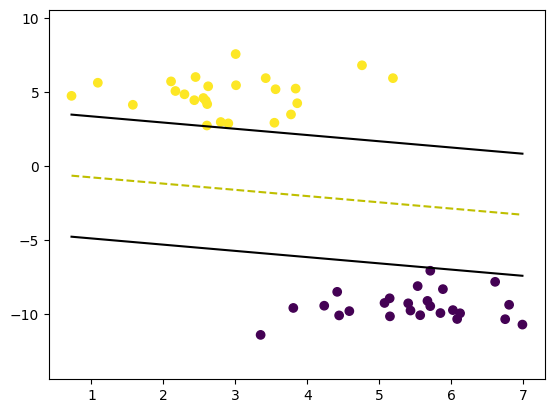

In [9]:
#plotting
def visualize_svm(w,b):
        def get_hyperplane_value(x, w, b, offset):
            return (-w[0] * x + b + offset) / w[1]

        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        plt.scatter(X[:, 0], X[:, 1], marker="o", c=y)

        x0_1 = np.amin(X[:, 0])
        x0_2 = np.amax(X[:, 0])

        x1_1 = get_hyperplane_value(x0_1, w, b, 0)
        x1_2 = get_hyperplane_value(x0_2, w, b, 0)

        x1_1_m = get_hyperplane_value(x0_1, w, b, -1)
        x1_2_m = get_hyperplane_value(x0_2, w, b, -1)

        x1_1_p = get_hyperplane_value(x0_1, w, b, 1)
        x1_2_p = get_hyperplane_value(x0_2, w, b, 1)

        ax.plot([x0_1, x0_2], [x1_1, x1_2], "y--")
        ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "k")
        ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k")

        x1_min = np.amin(X[:, 1])
        x1_max = np.amax(X[:, 1])
        ax.set_ylim([x1_min - 3, x1_max + 3])

        plt.show()

visualize_svm(w,b)

SVM using Langranges

In [10]:
from sklearn.metrics import accuracy_score

class SVM_Dual:
    def __init__(self, C=1.0, kernel='linear', degree=3, gamma=None, coef0=1.0, max_iter=1000):
        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
        self.max_iter = max_iter
        self.alpha = None
        self.b = 0
        self.support_vectors = None
        self.y_sv = None  # To store support vector labels
        self.X_train, self.y_train = None, None

    def _kernel(self, x1, x2):
        if self.kernel == 'linear':
            return x1 @ x2
        elif self.kernel == 'poly':
            return (self.gamma * (x1 @ x2) + self.coef0) ** self.degree
        elif self.kernel == 'rbf':
            return np.exp(-self.gamma * np.linalg.norm(x1 - x2)**2)
        else:
            raise ValueError("Invalid kernel")

    def fit(self, X, y):
        n_samples = X.shape[0]
        self.X_train, self.y_train = X, y
        y_ = np.where(y <= 0, -1, 1)
        
        if self.gamma is None:
            self.gamma = 1.0 / X.shape[1]

        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self._kernel(X[i], X[j])

        self.alpha = np.zeros(n_samples)
        
        for _ in range(self.max_iter):
            grad = 1 - y_ * (K @ (self.alpha * y_))
            self.alpha += 0.01 * grad
            self.alpha = np.clip(self.alpha, 0, self.C)

        # Identify support vectors and store their labels
        sv_mask = self.alpha > 1e-5
        self.support_vectors = X[sv_mask]
        self.alpha = self.alpha[sv_mask]
        self.y_sv = y_[sv_mask]  # Critical fix

        # Compute bias
        if len(self.alpha) > 0:
            self.b = np.mean(
                self.y_sv - 
                (self.alpha * self.y_sv) @ self._kernel_matrix(self.support_vectors)
            )

    def _kernel_matrix(self, X):
        return np.array([[self._kernel(x1, x2) for x2 in X] for x1 in X])

    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for i, x in enumerate(X):
            s = sum(
                self.alpha[j] * self.y_sv[j] * self._kernel(x, self.support_vectors[j]) 
                for j in range(len(self.support_vectors))  # Only loop over SVs
            )
            y_pred[i] = np.sign(s + self.b)
        return y_pred
    def decision_function(self, X):
        # Real-valued output before thresholding
        return np.array([
            np.sum(
                self.alpha[j] * self.y_train[j] * self._kernel(X[i], self.X_train[j])
                for j in np.where(self.alpha > 1e-5)[0]
            ) + self.b
            for i in range(X.shape[0])
        ])

In [11]:
# Initialize and train SVM
svm = SVM_Dual(kernel='rbf', C=1.0, gamma=0.5, max_iter=1000)
svm.fit(X_train, y_train)

In [12]:
# Predict and evaluate
y_pred = svm.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Test Accuracy: 1.00


C:\Users\junjo\AppData\Local\Temp\ipykernel_32992\1284493077.py:75: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(


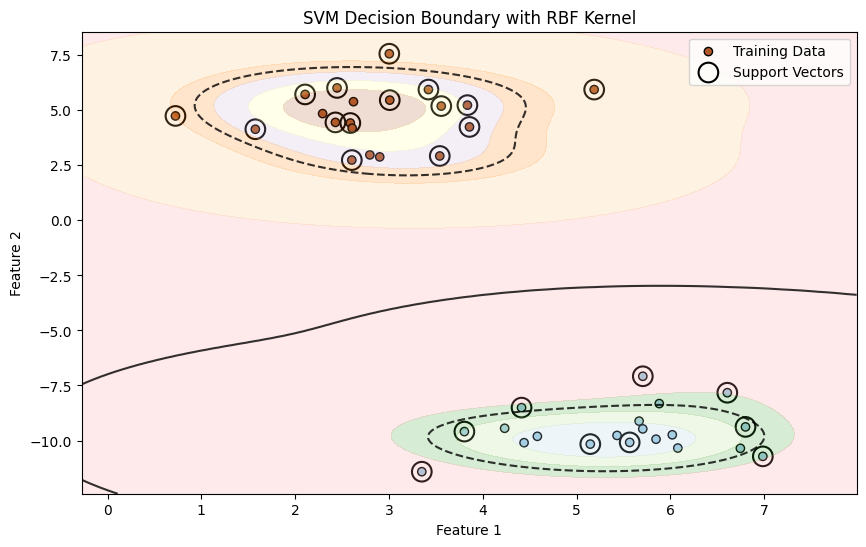

In [13]:
# Visualization
def plot_decision_boundary():
    plt.figure(figsize=(10, 6))
    
    # Plot training data
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, 
                edgecolors='k', label='Training Data')
    
    # Plot support vectors
    plt.scatter(svm.support_vectors[:, 0], svm.support_vectors[:, 1], 
                s=200, facecolors='none', edgecolors='k', linewidths=1.5, 
                label='Support Vectors')
    
    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Predict mesh grid
    Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary and margins
    plt.contour(xx, yy, Z, levels=[-1, 0, 1], alpha=0.8,
               linestyles=['--', '-', '--'], colors=['k', 'k', 'k'])
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 10), alpha=0.2, cmap=plt.cm.Paired)
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('SVM Decision Boundary with RBF Kernel')
    plt.legend()
    plt.show()

plot_decision_boundary()

Key Findings

Convergence & Optimality:

Gradient Descent: Convergence depends on step-size selection. The non-smooth hinge loss requires subgradient methods, which may converge slower.

Dual/Lagrange Method: The dual formulation (supported by KKT conditions) guarantees convergence to the global optimum in a convex setting, and the sparse nature of the solution (support vectors) is an inherent advantage.

Scalability & Efficiency:

For very large datasets, stochastic gradient descent may be preferable due to the quadratic scaling of the dual QP solver.

For smaller datasets or when kernel methods are needed, the dual formulation is more natural and flexible.

Kernelization:

The dual formulation easily incorporates kernel functions (linear, polynomial, RBF, etc.), making it straightforward to handle non-linearly separable data without an explicit mapping to high-dimensional spaces.

Gradient descent in the primal would require explicit feature transformations, which can be computationally expensive.

In [14]:
#Kernel implementations
def linear_kernel(x, y):
    return np.dot(x, y)

def polynomial_kernel(x, y, degree=3, gamma=1.0, coef0=1.0):
    return (gamma * np.dot(x, y) + coef0) ** degree

def rbf_kernel(x, y, gamma=None):
    if gamma is None:
        gamma = 1.0 / len(x)
    diff = x - y
    return np.exp(-gamma * np.dot(diff, diff))

# computing kernels for two sample vectors
if __name__ == "__main__":
    x = np.array([1.0, 2.0, 3.0])
    y = np.array([4.0, 5.0, 6.0])
    print("Linear Kernel:", linear_kernel(x, y))
    print("Polynomial Kernel:", polynomial_kernel(x, y, degree=2, gamma=0.5, coef0=1))
    print("RBF Kernel:", rbf_kernel(x, y, gamma=0.1))


Linear Kernel: 32.0
Polynomial Kernel: 289.0
RBF Kernel: 0.06720551273974976
